# Hotel Booking Demand
## Created by : Juan Josua Nainggolan

# Business Problem Understanding

**Context**  
Sebuah hotel bintang 5 memiliki masalah mengenai banyaknya pembatalan terhadap booking kamar yang sudah dilakukan oleh calon pengunjung. Hotel tersebut ingin mengetahui calon pengunjung mana yang benar-benar akan datang menginap atau yang hanya sekedar booking. Hal ini dikarenakan jika customer membatalkan booking yang sudah dilakukan, maka pihak hotel harus mencari penginap yang baru atau akan merugi karena telah menolak calon pengunjung yang tidak mendapat kamar karena sudah dibooking.

Target :

0 : Melakukan kunjungan dan menginap di hotel

1 : Membatalkan booking / tidak melakukan kunjungan

**Problem Statement :**
Hotel akan kehilangan banyak calon pengunjung jika setiap pengunjung yang ingin melakukan booking di approve tanpa penyaringan terlebih dahulu.

Hal ini disebabkan karena ketika pengunjung yang sudah melakukan booking membatalkan bookingnya, hotel harus mencari pengunjung yang lain yang akan menempati kamar, sementar hotel sudah menolak pengunjung lain yang sebelumnya berpotensi untuk menempati kamar.

**Goals :**
Hotel ingin memiliki kemampuan untuk menyaring calon pengunjung yang melakukan booking, sehingga meminimalisir pembatalan booking. Dan juga, perusahaan ingin mengetahui ciri-ciri calon pengunjung yang akan melakukan pembatalan booking.

**Analytic Approach :**
Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan calon pengunjung yang akan melakukan pembatalan booking dan yang tidak.

Kemudian kita akan membangun model klasifikasi yang akan membantu hotel untuk dapat memprediksi probabilitas seorang pengunjung akan membatalkan booking atau tidak.

# Data Understanding

Dataset Source : https://drive.google.com/file/d/1eeXOEY5B_zfSNhWeDDqPWCo9hAyDRAbc/view?usp=share_link

### Data Dictionary

- country : Country of origin. Categories are represented in the ISO 3155–3:2013 format
- market_segment : Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- previous_cancellations : Number of previous bookings that were cancelled by the customer prior to the current booking
- booking_changes : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
- deposit_type : Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.
- days_in_waiting_list : Number of days the booking was in the waiting list before it was confirmed to the customer
- customer_type : Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking
- reserved_room_type : Code of room type reserved. Code is presented instead of designation for anonymity reasons.
- required_car_parking_spaces : Number of car parking spaces required by the customer
- total_of_special_requests : Number of special requests made by the customer (e.g. twin bed or high floor)
- is_canceled : Value indicating if the booking was canceled (1) or not (0)

In [237]:
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [238]:
# Common Libraries used
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# For Statistical test
import scipy.stats as stats

# For modelling
from lightgbm import LGBMClassifier

# For evaluation
from sklearn.metrics import ConfusionMatrixDisplay

In [239]:
# reading the data and first five rows
url='https://drive.google.com/file/d/1eeXOEY5B_zfSNhWeDDqPWCo9hAyDRAbc/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [240]:
# info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


# Data Cleaning

## Check for data types and missing values

In [241]:
# detail information for each column
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[SYC, THA]"
1,market_segment,object,0,0.00,8,"[Aviation, Complementary]"
2,previous_cancellations,int64,0,0.00,15,"[21, 25]"
3,booking_changes,int64,0,0.00,19,"[12, 1]"
4,deposit_type,object,0,0.00,3,"[Refundable, Non Refund]"
5,days_in_waiting_list,int64,0,0.00,115,"[8, 61]"
6,customer_type,object,0,0.00,4,"[Transient, Group]"
7,reserved_room_type,object,0,0.00,10,"[E, B]"
8,required_car_parking_spaces,int64,0,0.00,5,"[0, 1]"
9,total_of_special_requests,int64,0,0.00,6,"[4, 2]"


Pertama kita akan menghilangkan baris yang tidak memiliki nilai country (null) karena dibandingkan dengan jumlah data yang kita miliki 83573, baris yang kosong hanya 351 dan ini jumlah yang kecil sekali.

In [242]:
df_clean = df[~df['country'].isnull()]
df_clean.shape

(83222, 11)

Selanjutnya kita akan merubah tipe data object menjadi category, serta kolom is_canceled dari integer menjadi object karena kolom ini merupakan kolom kategorikal bukan numerik.

In [243]:
# all object columns
c = df.select_dtypes('object').columns
df_clean[c] = df_clean[c].astype('category')

# change is_canceled data type
df_clean['is_canceled'] = df_clean['is_canceled'].astype('category')

Mari kita lihat lagi secara detail data yang sudah dibersihkan.

In [244]:
listItem = []
for col in df_clean.columns :
    listItem.append([col, df_clean[col].dtype, df_clean[col].isna().sum(), round((df_clean[col].isna().sum()/len(df_clean[col])) * 100,2),
                    df_clean[col].nunique(), list(df_clean[col].drop_duplicates().sample(2).values)]);

dfCleanDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfCleanDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,category,0,0.0,162,"[EST, MAC]"
1,market_segment,category,0,0.0,8,"[Corporate, Direct]"
2,previous_cancellations,int64,0,0.0,15,"[14, 4]"
3,booking_changes,int64,0,0.0,19,"[6, 8]"
4,deposit_type,category,0,0.0,3,"[Refundable, No Deposit]"
5,days_in_waiting_list,int64,0,0.0,115,"[121, 2]"
6,customer_type,category,0,0.0,4,"[Transient, Group]"
7,reserved_room_type,category,0,0.0,10,"[E, B]"
8,required_car_parking_spaces,int64,0,0.0,5,"[2, 0]"
9,total_of_special_requests,int64,0,0.0,6,"[4, 2]"


## Check for data imbalance

Sebelum kita masuk ke analisis, kita harus cek terlebih dahulu apakah jumlah data kita seimbang antara pengunjung yang membatalkan bookin dan yang tidak.

In [245]:
# Checking for class imbalance in the target variable
df_clean['is_canceled'].value_counts()

0    52490
1    30732
Name: is_canceled, dtype: int64

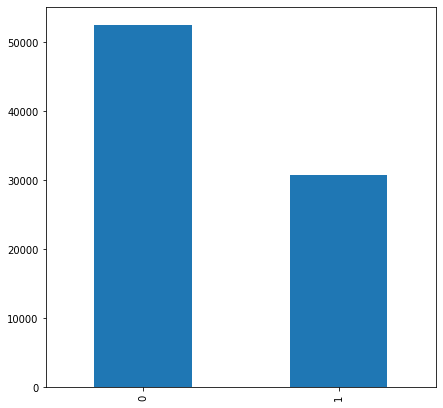

In [246]:
df_clean['is_canceled'].value_counts().plot.bar()
plt.show()

Perbandingan antara class 0 dan 1 tidak terlalu signifikan, sehingga tidak perlu di lakukan balancing.

## Group country using continent

Pada kolom country terdapat 162 unique values. Jumlah kategori ini sangat banyak dan mungkin akan menurunkan performa model kita nanti. Oleh karena itu, dapat dicoba mengelompokkan negara-negara dalam benua.

In [247]:
# We would bin the country column in its respective continents
europe=['PRT','GBR','ESP','IRL','FRA','ROU','NOR','POL','DEU','BEL','CHE','GRC','ITA','NLD','DNK','RUS','SWE','EST',
       'CZE','FIN','LUX','SVN','ALB','UKR','SMR','LVA','SRB','AUT','BLR','LTU','TUR','HUN','HRV','GEO','AND','SVK',
       'MKD','BIH','BGR','MLT','ISL','MCO','LIE','MNE']

north_a=['USA','MEX','PRI','CRI','CUB','HND','NIC','GAB','PAN','SLV','GTM']

south_a=['ARG','BRA','CHL','URY','COL','VEN','SUR','PER','ECU','BOL','PRY','GUY']

asia=['OMN','CN','IND','CHN','ISR','KOR','ARE','HKG','IRN','CYP','KWT','MDV','KAZ','PAK','IDN','LBN','PHL','AZE','BHR',
     'THA','MYS','ARM','JPN','LKA','JOR','SYR','SGP','SAU','VNM','QAT','UZB','NPL','MAC','TWN','IRQ','KHM','BGD','TJK',
     'TMP','MMR','LAO']

africa=['MOZ','BWA','MAR','ZAF','AGO','ZMB','ZWE','DZA','TUN','CAF','NGA','SEN','SYC','CMR','MUS','COM','UGA','CIV',
       'BDI','EGY','MWI','MDG','TGO','DJI','STP','ETH','RWA','BEN','TZA','GHA','KEN','GNB','BFA','LBY','MLI','NAM',
       'MRT','SDN','SLE']

australia=['AUS']

Others=['CYM','CPV','JAM','GIB','JEY','GGY','FJI','NZL','DOM','PLW','BHS','KNA','IMN','VGB','GLP','UMI','MYT','FRO',
       'BRB','ABW','AIA','DMA','PYF','LCA','ATA','ASM','NCL','KIR','ATF']

In [248]:
def continent(x):
    if x in europe:
        return 'Europe'
    elif x in north_a:
        return 'North America'
    elif x in south_a:
        return 'South America'
    elif x in asia:
        return 'Asia'
    elif x in africa:
        return 'Africa'
    elif x in australia:
        return 'Australia'
    else:
        return 'Others'

df_clean_grouped = df_clean.copy()
df_clean_grouped['country'] = df_clean_grouped['country'].apply(continent)
df_clean_grouped['country'] = df_clean_grouped['country'].astype('category')

In [249]:
df_clean_grouped['country'].unique()

['Europe', 'Others', 'Asia', 'South America', 'Africa', 'North America', 'Australia']
Categories (7, object): ['Africa', 'Asia', 'Australia', 'Europe', 'North America', 'Others',
                         'South America']

In [250]:
df_clean_grouped.shape

(83222, 11)

# Data Analysis

## Country

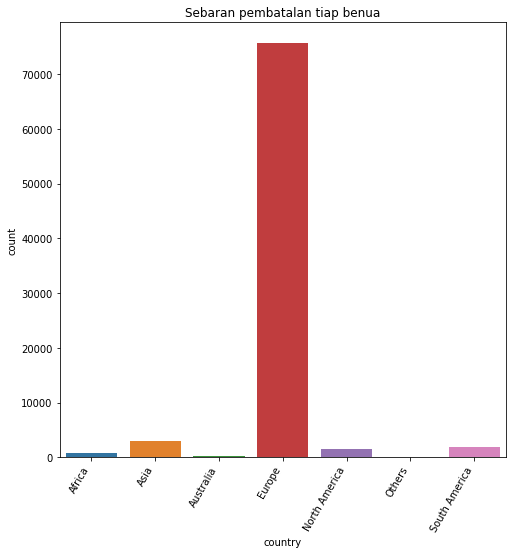

In [251]:
plt.figure(figsize=(8,8))
sns.countplot(x='country',data=df_clean_grouped)
plt.title('Sebaran pembatalan tiap benua')
plt.xticks(rotation=60,ha='right')
plt.show()

Kami melihat bahwa kebanyakan orang yang melakukan booking adalah orang Eropa. Dan yang terendah berasal dari Australia dan Others.

In [252]:
tbl=pd.crosstab(df_clean_grouped['country'],df_clean_grouped['is_canceled'],margins=True)
tbl

is_canceled,0,1,All
country,,,
Africa,430,316,746
Asia,2003,938,2941
Australia,225,76,301
Europe,47331,28320,75651
North America,1206,365,1571
Others,80,41,121
South America,1215,676,1891
All,52490,30732,83222


In [253]:
tbl['cancel_percent']=tbl[1]*100/tbl['All']
tbl

is_canceled,0,1,All,cancel_percent
country,,,,
Africa,430,316,746,42.359249
Asia,2003,938,2941,31.893914
Australia,225,76,301,25.249169
Europe,47331,28320,75651,37.435064
North America,1206,365,1571,23.233609
Others,80,41,121,33.884298
South America,1215,676,1891,35.748281
All,52490,30732,83222,36.927735


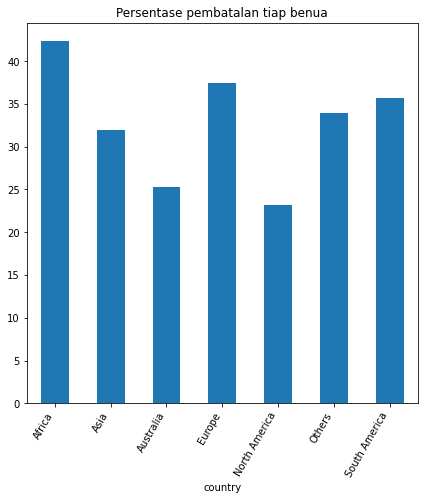

In [254]:
plt.figure(figsize=(7,7))
tbl.drop('All',axis=0)['cancel_percent'].plot.bar()
plt.title('Persentase pembatalan tiap benua')
plt.xticks(rotation=60,ha='right')
plt.show()

Dapat kita lihat bahwa benua yang memiliki tingkat pembatalan tertinggi merupakan benua Afrika, dan yang terendah merupakan Amerika Utara.

### Tes Statistik

h0: Tingkat pembatalan sama di semua wilayah negara

h1: Tingkat pembatalan tidak sama di semua wilayah negara

In [255]:
# Untuk tes ini kita akan menggunakan tes kontingensi chi2 
tbl=pd.crosstab(df_clean_grouped['country'],df_clean_grouped['is_canceled']) 
tbl

is_canceled,0,1
country,,
Africa,430,316
Asia,2003,938
Australia,225,76
Europe,47331,28320
North America,1206,365
Others,80,41
South America,1215,676


In [256]:
statistic,pvalue,dof,expected=stats.chi2_contingency(tbl)
print('Nilai P-Value =',pvalue)

Nilai P-Value = 1.6949608526107885e-39


Kita lihat bahwa nilai p-value sangat kecil. Oleh karena itu, kita dapat tolak h0. Kesimpulannya, tingkat pembatalan berbeda di semua benua.

## Market Segment

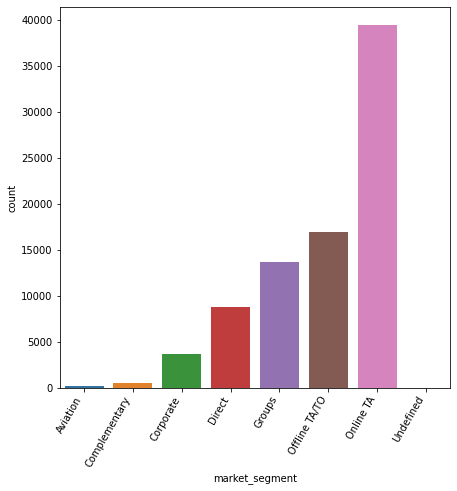

In [257]:
plt.rcParams['figure.figsize']=[7,7]
sns.countplot(x='market_segment',data=df_clean_grouped)
plt.xticks(rotation=60,ha='right')
plt.show()

Segmentasi pasar terbesar ada pada travel agen online. 

In [258]:
tbl=pd.crosstab(df_clean_grouped['market_segment'],df_clean_grouped['is_canceled'],margins=True)
tbl

is_canceled,0,1,All
market_segment,,,
Aviation,130,35,165
Complementary,438,68,506
Corporate,2990,678,3668
Direct,7437,1339,8776
Groups,5306,8412,13718
Offline TA/TO,11214,5766,16980
Online TA,24975,14433,39408
Undefined,0,1,1
All,52490,30732,83222


In [259]:
tbl['cancel_percent']=tbl[1]*100/tbl['All']
tbl

is_canceled,0,1,All,cancel_percent
market_segment,,,,
Aviation,130,35,165,21.212121
Complementary,438,68,506,13.438735
Corporate,2990,678,3668,18.484188
Direct,7437,1339,8776,15.257521
Groups,5306,8412,13718,61.320892
Offline TA/TO,11214,5766,16980,33.957597
Online TA,24975,14433,39408,36.624543
Undefined,0,1,1,100.000000
All,52490,30732,83222,36.927735


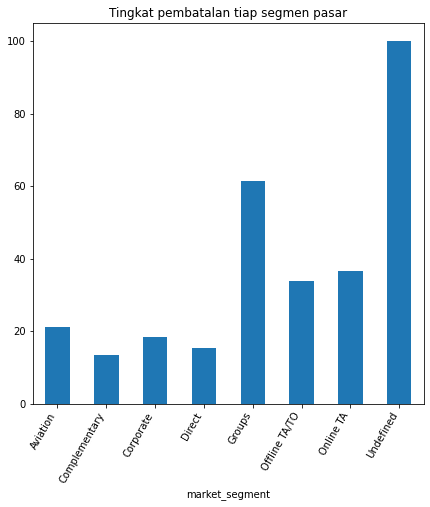

In [260]:
tbl.drop('All',axis=0)['cancel_percent'].plot.bar()
plt.title('Tingkat pembatalan tiap segmen pasar')
plt.xticks(rotation=60,ha='right')
plt.show()

Kami lihat bahwa segmen pasar yang tidak terdefinisi memiliki tingkat pembatalan tertinggi. Tapi hanya ada dua catatan dimana segmen pasar tidak terdefinisi. Di antara segmen pasar lainnya, tingkat pembatalan paling tinggi di segmen TA online.

### Tes Statistik

h0: Tingkat pembatalan sama di semua segmen pasar

h1: Tingkat pembatalan tidak sama di semua segmen pasar

In [261]:
# Untuk tes ini kita akan menggunakan tes kontingensi chi2
tbl = pd.crosstab(df_clean_grouped['market_segment'], df_clean_grouped['is_canceled'])
tbl

is_canceled,0,1
market_segment,,
Aviation,130,35
Complementary,438,68
Corporate,2990,678
Direct,7437,1339
Groups,5306,8412
Offline TA/TO,11214,5766
Online TA,24975,14433
Undefined,0,1


In [262]:
statistic, pvalue, dof, expected = stats.chi2_contingency(tbl)
print('Nilai P-Value =', pvalue)

Nilai P-Value = 0.0


Dapat kita lihat bahwa p-valuenya 0. Kesimpulannya, tingkat pembatalan berbeda-beda tiap market segment.

## Previous Cancellation

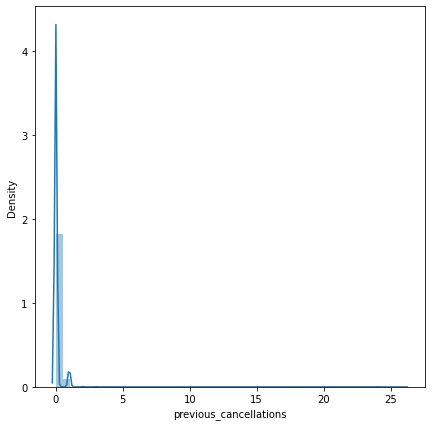

In [263]:
sns.distplot(df_clean_grouped['previous_cancellations'])
plt.show()

Dapat kita lihat bahwa sebagian besar pengunjung tidak memiliki pembatalan sebelumnya. Ini dapat disebabkan karena mayoritas pengunjung adalah pengunjung baru.

### Tes Statistik

h0: Jumlah rata-rata pembatalan sebelumnya sama antara pemesanan yang dibatalkan dan tidak dibatalkan


h1: Jumlah rata-rata pembatalan sebelumnya tidak sama antara pemesanan yang dibatalkan dan tidak dibatalkan

In [264]:
# Untuk pengujian ini kita akan menggunakan uji-t independen 2 sampel
# Untuk ini kami perlu membuat 2 sampel berbeda, satu untuk booking yang dibatalkan dan satu lagi untuk booking yang tidak dibatalkan
cancelled_sample = df_clean_grouped.loc[df_clean_grouped['is_canceled']==1, 'previous_cancellations']
non_cancelled_sample = df_clean_grouped.loc[df_clean_grouped['is_canceled']==0, 'previous_cancellations']

In [265]:
print('Nilai P-Value =',stats.ttest_ind(cancelled_sample,non_cancelled_sample)[1])

Nilai P-Value = 1.0544467056780734e-219


Dapat kita lihat bahwa p-value yang kita dapat sangat kecil. Oleh karena itu, kita tolak h0. Kesimpulannya, jumlah rata-rata pembatalan sebelumnya tidak sama di seluruh booking yang dibatalkan dan yang tidak dibatalkan.

## Booking Changes

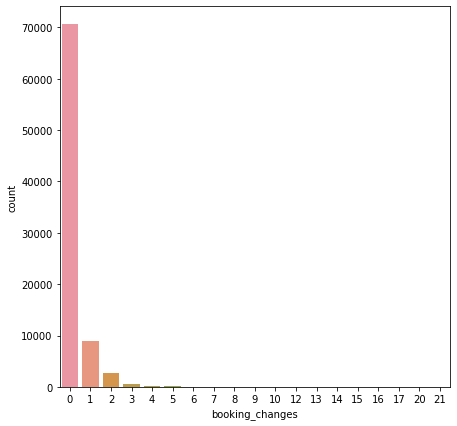

In [266]:
sns.countplot(x='booking_changes',data=df_clean_grouped)
plt.show()

Dapat kita lihat bahwa sebagian besar pengunjugan tidak melakukan perubahan apa pun pada booking mereka.

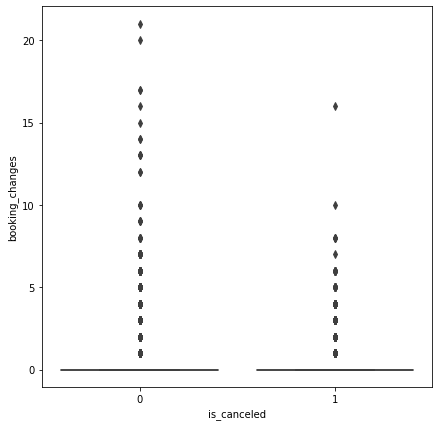

In [267]:
sns.boxplot(x='is_canceled',y='booking_changes',data=df_clean_grouped)
plt.show()

Kita lihat bahwa booking yang tidak dibatalkan memiliki jumlah perubahan yang lebih tinggi.

### Tes Statistik

h0: Jumlah rata-rata perubahan pada booking yang dibatalkan dan tidak dibatalkan adalah sama.

h1: Jumlah rata-rata perubahan pada booking yang dibatalkan dan yang tidak dibatalkan tidak sama

In [268]:
# Untuk pengujian ini kita akan menggunakan uji t 2 sampel independen
# Untuk ini kita perlu membuat dua sampel, satu untuk dibatalkan dan yang lainnya untuk tidak dibatalkan
cancelled_samp=df_clean_grouped.loc[df_clean_grouped['is_canceled']==1,'booking_changes']
non_cancelled_samp=df_clean_grouped.loc[df_clean_grouped['is_canceled']==0,'booking_changes']
print('Nilai P-Value =',stats.ttest_ind(cancelled_samp,non_cancelled_samp)[1])

Nilai P-Value = 0.0


Dapat kita lihat nilai p-value yang kita dapat sangat kecil. Oleh karena itu kita harus menolak hipotesis nol kita. Kesimpulannya, rata-rata jumlah perubahan pemesanan pada pemesanan yang dibatalkan dan yang tidak dibatalkan tidak sama.

## Deposit Type

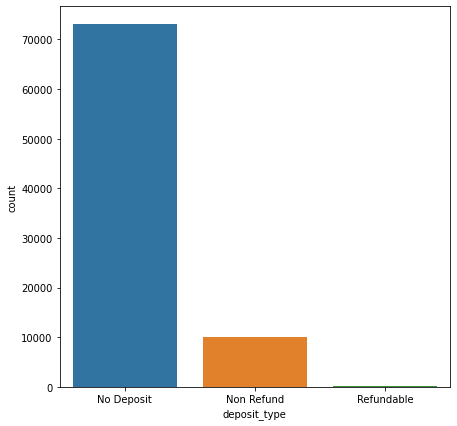

In [269]:
sns.countplot(x='deposit_type',data=df_clean_grouped)
plt.show()

Kita dapat melihat bahwa sebagian besar bookng dilakukan tanpa deposit, sangat sedikit booking yang dapat direfund dan tidak dapat direfund.

In [270]:
tbl=pd.crosstab(df_clean_grouped['deposit_type'],df_clean_grouped['is_canceled'],margins=True)
tbl

is_canceled,0,1,All
deposit_type,,,
No Deposit,52340,20672,73012
Non Refund,63,10037,10100
Refundable,87,23,110
All,52490,30732,83222


In [271]:
tbl['cancel_percent']=tbl[1]*100/tbl['All']

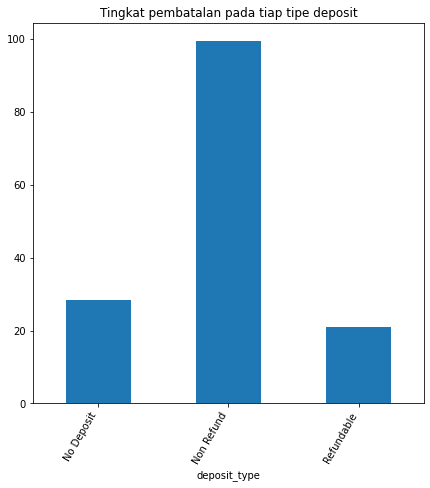

In [272]:
tbl.drop('All',axis=0)['cancel_percent'].plot.bar()
plt.xticks(rotation=60,ha='right')
plt.title('Tingkat pembatalan pada tiap tipe deposit')
plt.show()

Dari analisis kolom di atas kami menyimpulkan bahwa, tidak masuk akal ada persentase pembatalan yang sangat besar pada booking yang tidak dapat di refund.

### Tes Statistik

h0: Tingkat pembatalan di semua jenis deposit adalah sama.

h1: tingkat pembatalan di semua jenis deposit tidak sama.

In [273]:
# Untuk tes ini kita akan menggunakan tes chi2_contingency 
tbl=pd.crosstab(df_clean_grouped['deposit_type'],df['is_canceled']) 
tbl

is_canceled,0,1
deposit_type,,
No Deposit,52340,20672
Non Refund,63,10037
Refundable,87,23


In [274]:
statistic,pvalue,dof,exp=stats.chi2_contingency(tbl)
print('Nilai P-Value =',pvalue)

Nilai P-Value = 0.0


Kami melihat bahwa nilai p untuk pengujian kami menjadi nol. Oleh karena itu kita harus menolak hipotesis nol kita. Kesimpulannya, tingkat pembatalan tidak sama di semua jenis deposit.

## Days in Waiting List

h0: Jumlah rata-rata hari dalam daftar tunggu adalah sama untuk booking yang dibatalkan dan tidak dibatalkan 

h1: Jumlah hari rata-rata dalam daftar tunggu tidak sama di seluruh booking yang dibatalkan dan yang tidak dibatalkan

In [275]:
# Untuk pengujian ini kita akan menggunakan uji t 2 sampel independen
# Untuk ini kita perlu membuat dua sampel, satu untuk dibatalkan dan yang lainnya untuk tidak dibatalkan
cancelled_samp=df_clean_grouped.loc[df_clean_grouped['is_canceled']==1,'days_in_waiting_list']
non_cancelled_samp=df_clean_grouped.loc[df_clean_grouped['is_canceled']==0,'days_in_waiting_list']
print('Nilai P-Value =',stats.ttest_ind(cancelled_samp,non_cancelled_samp)[1])

Nilai P-Value = 7.883101551226524e-59


Dapat kita lihat bahwa nilai p-value yang kita peroleh sangat kecil, oleh karena itu kita dapat tolak h0. Dan memiliki kesimpulan bahwa jumlah hari dalam daftar tunggu tidak sama untuk booking yang dibatalkan dan tidak dibatalkan.

## Customer Type

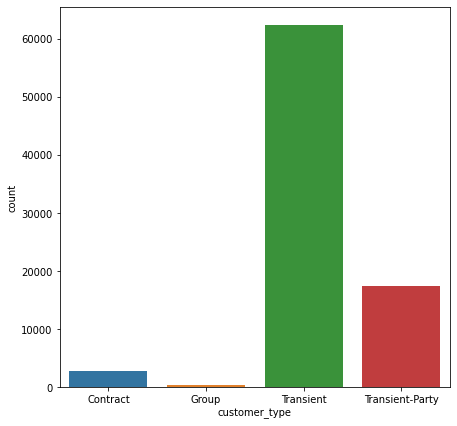

In [276]:
sns.countplot(x='customer_type',data=df_clean_grouped)
plt.show()

Sebagian besar booking berasal dari pelanggan sementara, artinya mereka menginap kurang dari 30 hari berturut-turut.

### Tes Statistik

h0: Tingkat pembatalan sama di semua jenis pelanggan 

h1: Tingkat pembatalan tidak sama di semua jenis pelanggan

In [277]:
# Untuk tes ini kita akan menggunakan tes chi2_contingency 
# Untuk ini kita perlu membuat tab silang yang diperlukan 
tbl=pd.crosstab(df_clean_grouped['customer_type'],df_clean_grouped['is_canceled']) 
tbl

is_canceled,0,1
customer_type,,
Contract,1997,885
Group,379,40
Transient,37083,25331
Transient-Party,13031,4476


In [278]:
statistic,pvalue,dof,exp=stats.chi2_contingency(tbl)
print('Nilai P-Value =',pvalue)

Nilai P-Value = 0.0


Kita lihat bahwa nilai p untuk tes yang diberikan sangat kecil. Oleh karena itu kita dapat menolak hipotesis nol kita. Kesimpulannya, tingkat pembatalan di semua jenis pengunjung tidak sama.

## Reserved Room Type

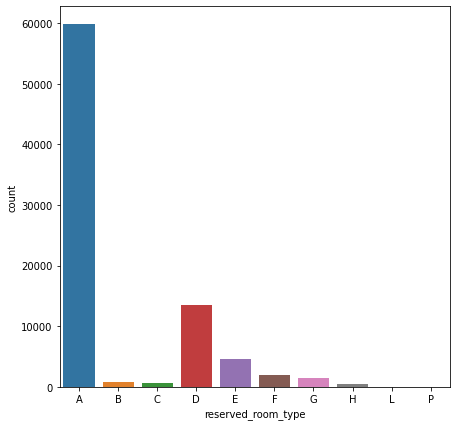

In [279]:
sns.countplot(x='reserved_room_type',data=df_clean_grouped)
plt.show()

Kamar hotel tipe A sepertinya menjadi tipe kamar yang paling banyak dipesan. Kamar ini bisa menjadi tipe kamar paling ekonomis yang tersedia di hotel. Sedangkan kamar L dan P memiliki data yang sangat sedikit, dan bisa jadi kamar-kamar ini merupakan kamar mewah / suite.

In [280]:
tbl=pd.crosstab(df_clean_grouped['reserved_room_type'],df_clean_grouped['is_canceled'],margins=True)
tbl

is_canceled,0,1,All
reserved_room_type,,,
A,36405,23356,59761
B,532,255,787
C,459,213,672
D,9237,4268,13505
E,3272,1349,4621
F,1426,606,2032
G,919,519,1438
H,238,163,401
L,2,1,3


In [281]:
tbl['cancel_percent']=tbl[1]*100/tbl['All']

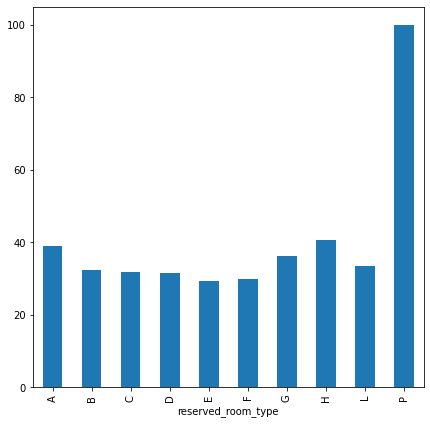

In [282]:
tbl.drop('All',axis=0)['cancel_percent'].plot.bar()
plt.show()

Kamar tipe P memiliki tingkat pembatalan tertinggi.

## Required Car Parking Spaces

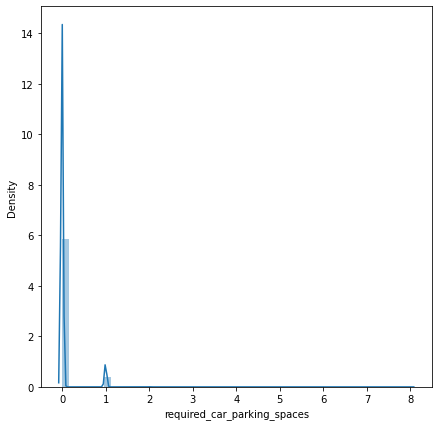

In [283]:
sns.distplot(df_clean_grouped['required_car_parking_spaces'])
plt.show()

Sebagian besar pesanan tidak memerlukan atau paling banyak 1 tempat parkir mobil, meskipun ada catatan yang menunjukkan jumlah tempat parkir lebih banyak. Ini bisa berupa keluarga yang bepergian bersama dan perjalanan bisnis yang lebih besar.

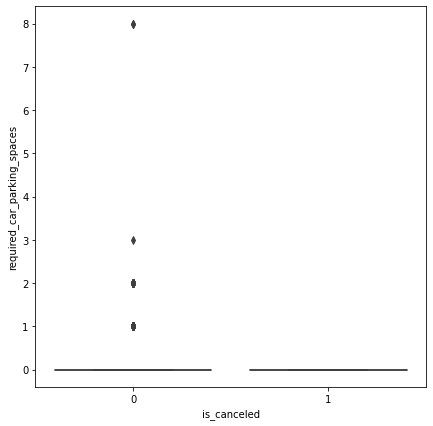

In [284]:
sns.boxplot(x='is_canceled',y='required_car_parking_spaces',data=df_clean_grouped)
plt.show()

Kami melihat bahwa booking yang tidak dibatalkan membutuhkan lebih banyak ruang parkir mobil dibandingkan dengan booking yang dibatalkan

### Tes Statistik

h0: Jumlah rata-rata ruang parkir mobil yang dibutuhkan sama untuk pemesanan yang dibatalkan dan yang tidak dibatalkan 

h1: Jumlah rata-rata ruang parkir mobil yang dibutuhkan tidak sama di seluruh pemesanan yang dibatalkan dan yang tidak dibatalkan

In [285]:
# Untuk pengujian ini kita akan menggunakan uji t 2 sampel independen
# Untuk ini kita perlu membuat dua sampel, satu untuk dibatalkan dan yang lainnya untuk tidak dibatalkan
cancelled_samp=df_clean_grouped.loc[df_clean_grouped['is_canceled']==1,'required_car_parking_spaces']
non_cancelled_samp=df_clean_grouped.loc[df_clean_grouped['is_canceled']==0,'required_car_parking_spaces']
print('Nilai P-Value =',stats.ttest_ind(cancelled_samp,non_cancelled_samp)[1])

Nilai P-Value = 0.0


Kita melihat bahwa nilai p untuk tes yang diberikan menjadi nol. Oleh karena itu kita harus menolak hipotesis nol kita. Kesimpulannya, rata-rata jumlah ruang parkir mobil yang dibutuhkan tidak sama antara pemesanan yang dibatalkan dan tidak dibatalkan

## Total of Special Requests

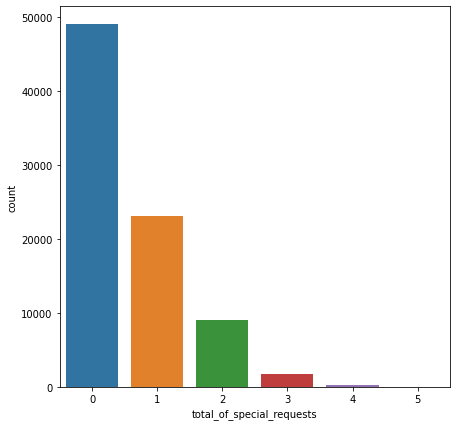

In [286]:
sns.countplot(x='total_of_special_requests',data=df_clean_grouped)
plt.show()

Kita lihat bahwa sebagian besar orang tidak membuat permintaan khusus apa pun untuk pemesanan mereka. Biasanya, jika ada permintaan khusus yang dibuat, terbatas pada 1 atau 2 permintaan khusus.

In [287]:
tbl=pd.crosstab(df_clean_grouped['total_of_special_requests'],df_clean_grouped['is_canceled'],margins=True)
tbl

is_canceled,0,1,All
total_of_special_requests,,,
0,25620,23331,48951
1,18037,5104,23141
2,7126,1963,9089
3,1470,306,1776
4,207,28,235
5,30,0,30
All,52490,30732,83222


In [288]:
tbl['cancel_percent']=tbl[1]*100/tbl['All']

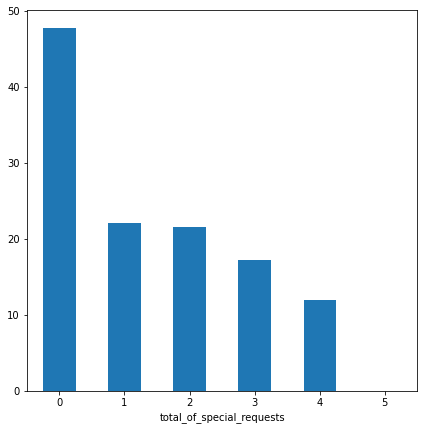

In [289]:
tbl.drop('All',axis=0)['cancel_percent'].plot.bar()
plt.xticks(rotation=0)
plt.show()

Dari atas kita melihat bahwa semakin banyak jumlah permintaan khusus yang dilakukan pengunjung, semakin kecil kemungkinan dia untuk membatalkan pemesanannya.

# Data Preparation

In [290]:
df_clean_grouped.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,Europe,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,Europe,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,Europe,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,Europe,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,Europe,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [291]:
listItem = []
for col in df.columns :
    listItem.append([col, df_clean_grouped[col].dtype, df_clean_grouped[col].isna().sum(), round((df_clean_grouped[col].isna().sum()/len(df_clean_grouped[col])) * 100,2),
                    df_clean_grouped[col].nunique(), list(df_clean_grouped[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,category,0,0.0,7,"[Africa, Europe]"
1,market_segment,category,0,0.0,8,"[Complementary, Undefined]"
2,previous_cancellations,int64,0,0.0,15,"[5, 19]"
3,booking_changes,int64,0,0.0,19,"[4, 21]"
4,deposit_type,category,0,0.0,3,"[Non Refund, Refundable]"
5,days_in_waiting_list,int64,0,0.0,115,"[120, 21]"
6,customer_type,category,0,0.0,4,"[Contract, Group]"
7,reserved_room_type,category,0,0.0,10,"[G, C]"
8,required_car_parking_spaces,int64,0,0.0,5,"[3, 1]"
9,total_of_special_requests,int64,0,0.0,6,"[1, 2]"


Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki.
Yang akan kita lakukan adalah :

1. Merubah fitur/kolom `deposit_type` dan `customer_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
2. Merubah fitur/kolom `country`, `market_segment` dan `reserved_room_type` menggunakan Binary Encoding, karena fitur-fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur baru yg terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.

In [292]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['deposit_type','customer_type']),
    ('binary', ce.BinaryEncoder(), ['country', 'market_segment', 'reserved_room_type'])
], remainder='passthrough')

In [293]:
x = df_clean_grouped.drop(columns=['is_canceled'])
y = df_clean_grouped['is_canceled']

In [294]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3,random_state=999)

In [295]:
testing = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names())
testing.head()

,onehot__x0_Non Refund,onehot__x0_Refundable,onehot__x1_Group,onehot__x1_Transient,onehot__x1_Transient-Party,binary__country_0,binary__country_1,binary__country_2,binary__market_segment_0,binary__market_segment_1,binary__market_segment_2,binary__reserved_room_type_0,binary__reserved_room_type_1,binary__reserved_room_type_2,binary__reserved_room_type_3,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modeling & Evaluation

In [296]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

### Model Benchmarking : K-Fold

In [297]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
LightGBM,0.858029,0.002247
Random Forest,0.855248,0.002215
Decision Tree,0.852274,0.002549
XGBoost,0.847987,0.001540
Logistic Regression,0.828858,0.002490
KNN,0.812750,0.012785


Terlihat bahwa model LightGBM adalah yang terbaik untuk roc_aucnya dari setiap model yang menggunakan default hyperparameter

### Model Benchmarking : Test Data

In [298]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.79      0.91      0.85     15747
           1       0.80      0.59      0.68      9220

    accuracy                           0.79     24967
   macro avg       0.79      0.75      0.76     24967
weighted avg       0.79      0.79      0.78     24967

KNN 
               precision    recall  f1-score   support

           0       0.76      0.86      0.81     15747
           1       0.69      0.54      0.61      9220

    accuracy                           0.74     24967
   macro avg       0.73      0.70      0.71     24967
weighted avg       0.74      0.74      0.73     24967

Decision Tree 
               precision    recall  f1-score   support

           0       0.80      0.90      0.85     15747
           1       0.79      0.62      0.70      9220

    accuracy                           0.80     24967
   macro avg       0.80      0.76      0.77     24967
weighted avg       0.80      0

,roc_auc score
model,
LightGBM,0.857681
Random Forest,0.855360
Decision Tree,0.853165
XGBoost,0.849837
Logistic Regression,0.831538
KNN,0.771052


Terlihat model LightGBM kembali merupakan model dengan performa terbaik pada test data.

Sekarang kita coba lakukan oversampling untuk model LightGBM kita, untuk melihat apakah kita dapat mendapatkan hasil yang lebih baik lagi.

### Test Oversampling with K-Fold Cross Validation

In [299]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [300]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [301]:
data = x_train
target = y_train

In [302]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
    #print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

#### Evaluation Metrics Without Oversampling

In [303]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.804707,0.802266,0.862671,0.864445,0.778316,0.774074,0.622417,0.607807,0.804460,0.809406
1,0.804765,0.802094,0.862260,0.861560,0.777736,0.776280,0.617510,0.625929,0.808535,0.794690
2,0.804612,0.806557,0.862431,0.862925,0.777677,0.779434,0.618150,0.617387,0.807612,0.813725
3,0.804536,0.804669,0.862367,0.863087,0.777523,0.776197,0.617530,0.606695,0.807892,0.817157
4,0.805356,0.801922,0.862833,0.860691,0.778486,0.776292,0.618873,0.627615,0.809157,0.792719
5,0.804730,0.800515,0.864211,0.846884,0.777715,0.770942,0.617582,0.597397,0.808397,0.812777
6,0.805131,0.803433,0.863687,0.852906,0.778402,0.776077,0.619906,0.614598,0.807672,0.807082
7,0.805093,0.805494,0.863168,0.856561,0.778578,0.779203,0.621559,0.623431,0.806244,0.805889
8,0.805226,0.800858,0.863495,0.855104,0.778300,0.774395,0.618408,0.620642,0.809151,0.795116
9,0.804978,0.804635,0.862742,0.861349,0.778309,0.778556,0.620319,0.624826,0.806907,0.802388


#### Evaluation Metrics With Oversampling

In [304]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.771281,0.802437,0.862842,0.864184,0.768365,0.778841,0.659076,0.644052,0.849774,0.782609
1,0.771312,0.794370,0.862963,0.861693,0.768206,0.772723,0.655569,0.657528,0.853034,0.754264
2,0.769626,0.803296,0.862797,0.861910,0.765920,0.779217,0.643795,0.640632,0.860301,0.786979
3,0.771637,0.803124,0.863457,0.863027,0.768363,0.778996,0.652746,0.640167,0.856378,0.786857
4,0.770458,0.795572,0.863311,0.860297,0.766946,0.773329,0.647696,0.653185,0.858471,0.759459
5,0.770661,0.792961,0.864765,0.847158,0.767438,0.767696,0.652938,0.627150,0.854013,0.769538
6,0.772476,0.796738,0.865328,0.851935,0.769632,0.774399,0.661375,0.652720,0.850317,0.762629
7,0.771569,0.798283,0.863297,0.856308,0.768473,0.776247,0.655932,0.655974,0.853271,0.764355
8,0.771962,0.793476,0.864839,0.855155,0.769170,0.772152,0.661979,0.660158,0.848653,0.750529
9,0.772249,0.799485,0.864446,0.861458,0.769160,0.777447,0.656567,0.656439,0.854198,0.766974


Terlihat bahwa hasil evaluation metricsnya untuk recall dari class positive lebih baik setelah di oversampling dari yang tidak di oversampling tetapi precisionnya tebakan class positive menjadi sedikit lebih buruk. 

Ini masuk akal karena class positive datanya kita perbanyak menjadi sama dengan jumlah data dari class negative, dimana ini biasa memang akan membuat recall dari class yg minoritas naik tetapi otomatis biasa precisionnya juga akan turun sebagai dampaknya. Tetapi untuk kasus kali ini recallnya naik lebih tinggi dari pada precisionnya yang turun. Dan dampak ini terhadap kasus permasalahan kita berarti model kita setelah di oversampling, menjadi mendapatkan potensial cancel booking yang lebih banyak dari sebelumnya, tetapi sedikit berkurang dalam ketepatan/precision tebakannya untuk cancel booking, yang menyebabkan opportunity cost hotel yang terbuang.

Mari sekarang kita lihat juga classification reportsnya.

#### Classification Reports Without Oversampling

In [305]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      3674
           1       0.81      0.61      0.69      2152

    accuracy                           0.80      5826
   macro avg       0.80      0.76      0.77      5826
weighted avg       0.80      0.80      0.79      5826

              precision    recall  f1-score   support

           0       0.81      0.91      0.85      3674
           1       0.79      0.63      0.70      2152

    accuracy                           0.80      5826
   macro avg       0.80      0.77      0.78      5826
weighted avg       0.80      0.80      0.80      5826

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3675
           1       0.81      0.62      0.70      2151

    accuracy                           0.81      5826
   macro avg       0.81      0.77      0.78      5826
weighted avg       0.81      0.81      0.80      5826

              preci

#### Classification Reports With Oversampling

In [306]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3674
           1       0.78      0.64      0.71      2152

    accuracy                           0.80      5826
   macro avg       0.80      0.77      0.78      5826
weighted avg       0.80      0.80      0.80      5826

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3674
           1       0.75      0.66      0.70      2152

    accuracy                           0.79      5826
   macro avg       0.78      0.77      0.77      5826
weighted avg       0.79      0.79      0.79      5826

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3675
           1       0.79      0.64      0.71      2151

    accuracy                           0.80      5826
   macro avg       0.80      0.77      0.78      5826
weighted avg       0.80      0.80      0.80      5826

              preci

Terlihat bahwa model yang setelah di oversampling memiliki recall dari kedua class yang lebih seimbang. Oleh karena itu untuk kasus kali ini, mari kita gunakan model yang menggunakan oversampling (menggunakan asumsi yang kedua (yaitu kita membutuhkan booking potensial yang lebih banyak)).

Sekarang mari kita coba melakukan hyperparameter tuning pada model LightGBM kita untuk mendapatkan hasil yang lebih baik lagi.

### Hyperparameter Tuning

In [307]:
lgbm = lgb.LGBMClassifier()
ros = RandomOverSampler(random_state=999)

estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])

In [308]:
hyperparam_space=[{
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves':[31, 21, 41, 51],
    'model__min_data_in_leaf': [20, 15, 30, 40],
    'model__num_iterations':[100,75, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [999]
}]

In [309]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [310]:
halving_cv = HalvingGridSearchCV(
    estimator, param_grid=hyperparam_space, scoring="roc_auc", n_jobs=-1, min_resources="exhaust", factor=3
)

halving_cv.fit(x_train,y_train)
print(halving_cv.best_score_)
print(halving_cv.best_params_)

0.8565093914670161
{'model__learning_rate': 0.075, 'model__max_bin': 255, 'model__min_data_in_leaf': 20, 'model__num_iterations': 75, 'model__num_leaves': 31, 'model__random_state': 999}


Hyperparameter terbaik LGBM dari hasil HalvingGridsearch => `max_bin` = 255, `num_leaves` = 31, `min_data_in_leaf` = 20, `num_iterations` = 75, `learning_rate` = 0.075

In [311]:
best_model = halving_cv.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=999)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.075, max_bin=255,
                                min_data_in_leaf=20, num_iterations=75,
                                random_state=999))])

In [312]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=999)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('model', LGBMClassifier())])

In [313]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

ROC AUC Score Default LGBM :  0.8574189182059537
ROC AUC Score Tuned LGBM :  0.8568784922982955


Terlihat bahwa model LGBM setelah kita tuning hyperparameternya memiliki nilai ROC AUC yang lebih baik walaupun hanya naik sedikit saja.

Mari kita lihat juga perbandingan classification reportnya

In [314]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84     15747
           1       0.76      0.65      0.70      9220

    accuracy                           0.79     24967
   macro avg       0.78      0.76      0.77     24967
weighted avg       0.79      0.79      0.79     24967

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85     15747
           1       0.77      0.64      0.70      9220

    accuracy                           0.80     24967
   macro avg       0.79      0.76      0.77     24967
weighted avg       0.79      0.80      0.79     24967



Kembali lagi terlihat bahwa model LGBM setelah kita tuning hyperparameternya memiliki classification report yang lebih baik walaupun hanya lebih baik sedikit saja. Oleh karena itu kita akan menggunakan model LGBM yang sudah di tuned sebagai model akhir kita.

### Feature Importances

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model LGBM kita

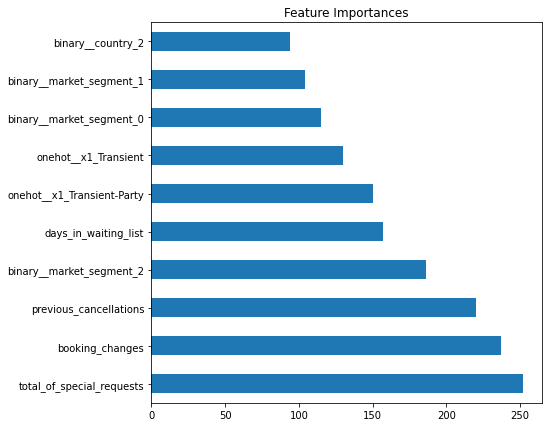

In [315]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Terlihat bahwa ternyata untuk model LGBM kita, fitur/kolom total_of_special_requests adalah yang paling penting, kemudian diikuti dengan booking_changes, previous_cancellations, dan selanjutnya.

## Conclusion & Recommendation

In [316]:
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85     15747
           1       0.77      0.64      0.70      9220

    accuracy                           0.80     24967
   macro avg       0.79      0.76      0.77     24967
weighted avg       0.79      0.80      0.79     24967



Berdasarkan hasil classification report dari model kita, kita dapat menyimpulkan/mengambil konklusi bahwa bila seandainya nanti kita menggunakan model kita untuk memfilter/menyaring list kandidat yang akan kita coba tawarkan, maka model kita dapat menemukan 89% booking yang tidak akan dibatalkan, dan model kita dapat mendapatkan 64% reservasi / booking yang berpotensi dibatalkan. (semua ini berdasarkan recallnya)

Model kita ini memiliki ketepatan prediksi sebesar 77% (precisionnya), jadi setiap model kita memprediksi bahwa sebuah reservasi / booking akan dibatalkan, dan kemungkinan tebakannya itu benar adalah 77%.

#### Recommendation

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :
- Menambahkan fitur2 atau kolom2 baru yang kemungkinan bisa berhubungan dengan pembatalan, seperti tujuan menginap, berapa banyak orang yang menginap, dll.
- Mencoba algorithm ML yang lain dan juga mencoba hyperparameter tuning kembali, coba gunakan teknik oversampling yang berbeda juga selain Random Over Sampling, seperti SMOTENC, dll. 
- Menganalisa data-data yang model kita masih salah tebak untuk mengetahui alasannya dan karakteristiknya bagaimana.